In [15]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

DELETION_TYPE = 'long'

In [16]:
import pandas as pd 
import numpy as np 

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

## Large windows with overlapping large deletions

In [17]:
def read_large_windows_intersect_deletions():
  df = pd.read_csv(
    f"{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/filtered-large-windows-with-{DELETION_TYPE}-deletions.aggregated.bed", 
    sep = '\t',
  )  
  return df 

read_large_windows_intersect_deletions() 

,chrom,start,end,number_of_overlapping_topmed_deletions,large_window-merged_deletion overlap
0,chr1,2300000,2400000,4,60303
1,chr1,2400000,2500000,2,74431
2,chr1,2500000,2600000,1,2537
3,chr1,2600000,2700000,3,37639
4,chr1,2800000,2900000,6,63623
...,...,...,...,...,...
24980,chr9,133900000,134000000,10,88278
24981,chr9,134000000,134100000,2,100000
24982,chr9,134200000,134300000,8,82201
24983,chr9,134300000,134400000,0,0


## Critical and noncritical genes

In [18]:
def read_critical_genes():
  df = pd.read_csv(
    f"{CONSTRAINT_TOOLS_DATA}/genes/grch38/critical.genes.sorted.bed", 
    sep = '\t',
    header=None,
    names=['chrom', 'start', 'end', 'gene'],
  )  
  return df 

read_critical_genes().head()

,chrom,start,end,gene
0,chr1,6785454,7769706,CAMTA1
1,chr1,10210570,10381603,KIF1B
2,chr1,11012344,11030528,TARDBP
3,chr1,11273198,11296049,UBIAD1
4,chr1,11845709,11848345,NPPA


In [19]:
def read_noncritical_genes():
  df = pd.read_csv(
    f"{CONSTRAINT_TOOLS_DATA}/genes/grch38/noncritical.genes.sorted.bed", 
    sep = '\t',
    header=None,
    names=['chrom', 'start', 'end', 'gene'],
  )  
  return df 

read_noncritical_genes().head()

,chrom,start,end,gene
0,chr1,65419,71585,OR4F5
1,chr1,450740,451678,OR4F29
2,chr1,685716,686654,OR4F16
3,chr1,923923,944575,SAMD11
4,chr1,944203,959309,NOC2L


## Compute number of critical and noncritical genes that overlap each large window


In [20]:
from shell import shell

def compute_true_constraint(row): 
  if row['critical_gene_count'] > 0: 
    return 'high (critical_gene_count > 0)' 
  if row['noncritical_gene_count'] > 0: 
    return 'medium (noncritical_gene_count > 0)'
  return 'low (no genes)'

def intersect_large_windows_with_critical_and_noncritical_genes():
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/filtered-large-windows-with-{DELETION_TYPE}-deletions.aggregated.bed)"
    f" -b" 
    f" {CONSTRAINT_TOOLS_DATA}/genes/grch38/critical.genes.sorted.bed"
    f" {CONSTRAINT_TOOLS_DATA}/genes/grch38/noncritical.genes.sorted.bed"
    f' -names critical noncritical'
    f' -C'
    f' -f 0.1'
    f' | sort -k1,1V -k2,2n'
    f' > {CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-with-{DELETION_TYPE}-deletions-and-gene-counts.bed'
  )
  shell(cmd)

  index = [
    'chrom', 'start', 'end', 'number_of_overlapping_topmed_deletions', 'large_window-merged_deletion overlap',
  ]
  df = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/large-windows-with-{DELETION_TYPE}-deletions-and-gene-counts.bed', 
    sep='\t',
    names=index + ['gene_class', 'number_of_overlapping_genes'],
  )
  df = df.pivot(
    index=index, 
    columns='gene_class', 
    values='number_of_overlapping_genes'
  ) 
  df = df.rename(columns={'critical': 'critical_gene_count', 'noncritical': 'noncritical_gene_count'})
  df = df.reset_index()
  df = df.rename_axis('index', axis=1) # rename index column

  df['gene_counts'] = list(zip(df['critical_gene_count'], df['noncritical_gene_count']))
  
  print('gene counts (critical, noncritical) and number of windows')
  print(df['gene_counts'].value_counts())

  df['true_constraint'] = df.apply(compute_true_constraint, axis=1)

  return df 

intersect_large_windows_with_critical_and_noncritical_genes()


gene counts (critical, noncritical) and number of windows
(0, 1)     10101
(0, 0)      9647
(0, 2)      3066
(0, 3)       915
(1, 0)       627
(1, 1)       276
(0, 4)       174
(1, 2)        80
(0, 5)        34
(1, 3)        26
(2, 0)        10
(1, 4)         6
(2, 2)         5
(2, 1)         4
(0, 6)         4
(0, 7)         2
(0, 15)        2
(2, 3)         1
(0, 10)        1
(0, 13)        1
(0, 12)        1
(0, 22)        1
(1, 22)        1
Name: gene_counts, dtype: int64


index,chrom,start,end,number_of_overlapping_topmed_deletions,large_window-merged_deletion overlap,critical_gene_count,noncritical_gene_count,gene_counts,true_constraint
0,chr1,2300000,2400000,4,60303,0,2,"(0, 2)",medium (noncritical_gene_count > 0)
1,chr1,2400000,2500000,2,74431,0,1,"(0, 1)",medium (noncritical_gene_count > 0)
2,chr1,2500000,2600000,1,2537,0,1,"(0, 1)",medium (noncritical_gene_count > 0)
3,chr1,2600000,2700000,3,37639,0,2,"(0, 2)",medium (noncritical_gene_count > 0)
4,chr1,2800000,2900000,6,63623,0,0,"(0, 0)",low (no genes)
...,...,...,...,...,...,...,...,...,...
24980,chr9,133900000,134000000,10,88278,0,1,"(0, 1)",medium (noncritical_gene_count > 0)
24981,chr9,134000000,134100000,2,100000,0,1,"(0, 1)",medium (noncritical_gene_count > 0)
24982,chr9,134200000,134300000,8,82201,0,0,"(0, 0)",low (no genes)
24983,chr9,134300000,134400000,0,0,0,1,"(0, 1)",medium (noncritical_gene_count > 0)


## Deletion density differentiates constrained from unconstrained regions


gene counts (critical, noncritical) and number of windows
(0, 1)     10101
(0, 0)      9647
(0, 2)      3066
(0, 3)       915
(1, 0)       627
(1, 1)       276
(0, 4)       174
(1, 2)        80
(0, 5)        34
(1, 3)        26
(2, 0)        10
(1, 4)         6
(2, 2)         5
(2, 1)         4
(0, 6)         4
(0, 7)         2
(0, 15)        2
(2, 3)         1
(0, 10)        1
(0, 13)        1
(0, 12)        1
(0, 22)        1
(1, 22)        1
Name: gene_counts, dtype: int64
average score for low (no genes): 6.239659997926816
average score for medium (noncritical_gene_count > 0): 3.945811774576982
average score for high (critical_gene_count > 0): 3.135135135135135



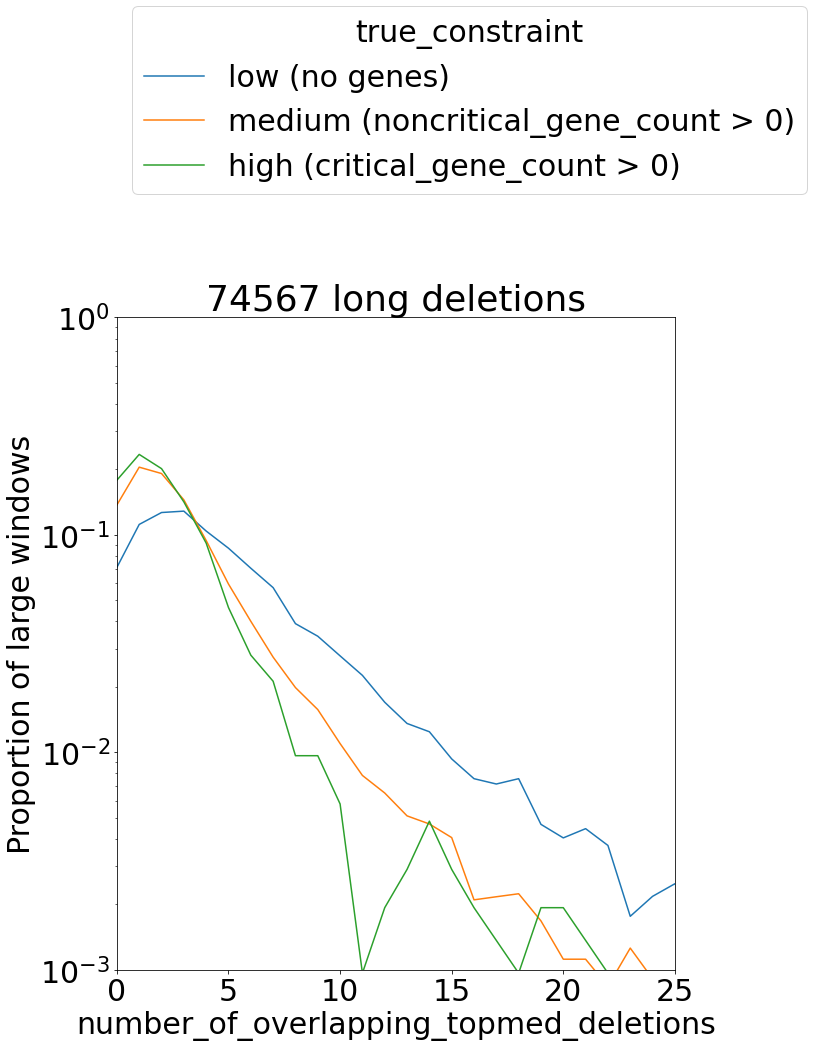

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font size
mpl.rcParams['font.size'] = 30

def read_number_deletions(): 
  cmd = f'cat {CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/number-{DELETION_TYPE}-deletions.txt'
  return int(shell(cmd))

def plot_score_distribution(df, score, condition_label): 
  print(f'average score for {condition_label}: {np.mean(np.array(df[score]))}')

  ser = df[score].value_counts()
  unique_scores = np.array(ser.index)
  window_counts = np.array(ser)
  total_number_windows = np.sum(window_counts)
  probs = window_counts / total_number_windows

  sorted_indices = sorted(range(len(unique_scores)), key=lambda k: unique_scores[k])
  unique_scores = [unique_scores[i] for i in sorted_indices]
  probs = [probs[i] for i in sorted_indices]

  plt.plot(unique_scores, probs, label=condition_label)

def plot_score_distributions(
    df, score, condition, condition_labels, legend_title,  
    xscale='linear', yscale='log', xlim=[0, 25], ylim=[1e-3, 1], xlabel=None, ylabel=None,
    plot_function=plot_score_distribution
): 
  for condition_label in condition_labels: 
    plot_function(
      df[df[condition] == condition_label], 
      score, 
      condition_label,
    )

  if xlabel is None: xlabel = score
  plt.xlabel(xlabel)
  plt.ylabel('Proportion of large windows')
  plt.xscale(xscale) # type: ignore
  plt.yscale(yscale) # type: ignore
  plt.xlim(xlim)
  plt.ylim(ylim)

  legend_bbox = (0, 1.5)
  legend_loc = 'upper left'
  (
    plt
      .legend(bbox_to_anchor=legend_bbox, loc=legend_loc)
      .set_title(legend_title)
  )

  plt.title(
    f'{read_number_deletions()} {DELETION_TYPE} deletions'
  )
  fig = plt.gcf()
  fig.set_size_inches(10, 12)
  plt.show()

plot_score_distributions(
  df=intersect_large_windows_with_critical_and_noncritical_genes() ,
  score='number_of_overlapping_topmed_deletions',
  condition='true_constraint', 
  condition_labels=['low (no genes)', 'medium (noncritical_gene_count > 0)', 'high (critical_gene_count > 0)'],
  legend_title='true_constraint',
)
